In [1]:
import torch
from torch import nn

c:\Users\gabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
ROOT_FOLDER = 'munch/dataset'
CHECKPOINTS_PATH = 'munch/checkpoints'

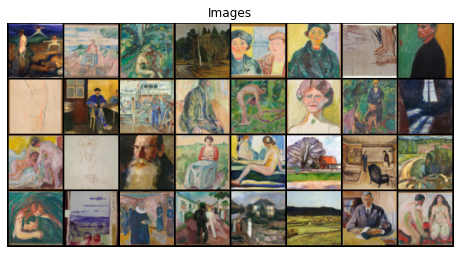

In [3]:
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.utils
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np


ds = dataset.ImageFolder(root=ROOT_FOLDER, transform=transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),

    # Mean and std per channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
]))

loader = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def init_weights(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)


In [5]:
nc = 3  # Number of channels
lsz = 100  # Latent space size, input

ngf = 64  # Number of generator filters
ndf = 64  # Number of discriminator filters

g_convolution_sizes = [
    lsz,
    ngf * 8,  # 4x4
    ngf * 4,  # 8x8
    ngf * 2,  # 16x16
    ngf,  # 32x32
]


def make_generator_convolution_layer(sz_input, sz_output):
    stride = 2
    padding=1
    if sz_input == lsz:
        stride = 1
        padding = 0
    return nn.Sequential(
        nn.ConvTranspose2d(
            sz_input, sz_output, kernel_size=4, stride=stride, padding=padding, bias=False
        ),
        nn.BatchNorm2d(sz_output),
        nn.ReLU(True),
    )


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            *[
                make_generator_convolution_layer(
                    g_convolution_sizes[i], g_convolution_sizes[i + 1]
                )
                for i in range(len(g_convolution_sizes) - 1)
            ],
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


In [6]:
generator = Generator().to(device)
generator.apply(init_weights)
print(generator)

Generator(
  (main): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [7]:
d_convolution_sizes = [
    ndf,
    ndf*2, 
    ndf*4, 
    ndf*8
]

def make_discriminator_convolution_layer(sz_input, sz_output):
    return nn.Sequential(
        nn.Conv2d(sz_input, sz_output, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(sz_output),
        nn.LeakyReLU(0.2, inplace=True),
    )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            *[
                make_discriminator_convolution_layer(
                    d_convolution_sizes[i], d_convolution_sizes[i + 1]
                )
                for i in range(len(d_convolution_sizes) - 1)
            ],
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [8]:
discriminator = Discriminator().to(device)
discriminator.apply(init_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel

In [18]:
loss = nn.BCELoss()

generated_grids = []
fixed_noise = torch.randn(64, lsz, 1, 1, device=device)

real_label = 1
fake_label = 0

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00025, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00025, betas=(0.5, 0.999))

# Checkpoint Saving/Loading

In [11]:
def save_checkpoint(epoch, model, optimizer, loss, filename_preffix="default"):
    print("=> Saving checkpoint")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, f"{CHECKPOINTS_PATH}/{filename_preffix}_epoch_{epoch}.pt")

def load_checkpoint(model, optimizer, filename):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

def load_discriminator_checkpoint(filename):
    return load_checkpoint(discriminator, d_optimizer, filename)

def load_generator_checkpoint(filename):
    return load_checkpoint(generator, g_optimizer, filename)

## Load specific checkpoint

In [12]:
# load_discriminator_checkpoint(f"{CHECKPOINTS_PATH}/discriminator_epoch_490.pt")
# load_generator_checkpoint(f"{CHECKPOINTS_PATH}/generator_epoch_490.pt")

In [19]:
d_losses = []
g_losses = []

num_epochs = 200
img_list = []

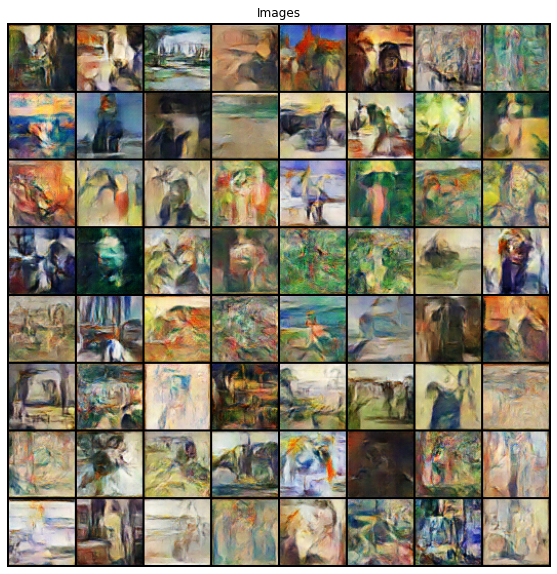

In [20]:
from IPython.display import clear_output

for epoch in range(num_epochs):
 
    for i, data in enumerate(loader, 0):

        # ====================
        # DISCRIMINATOR TRAINING

        # Real pass
        discriminator.zero_grad()

        batch = data[0].to(device)
        batch_size = batch.size(0)

        y_pred = discriminator(batch).view(-1)

        labels = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
        loss_real = loss(y_pred, labels)
        loss_real.backward()

        # Fake pass
        z = torch.randn(batch_size, lsz, 1, 1, device=device)
        fake = generator(z)

        y_pred = discriminator(fake.detach()).view(-1)

        labels.fill_(fake_label)
        loss_fake = loss(y_pred, labels)
        loss_fake.backward()

        d_loss_total = loss_real + loss_fake
        d_losses.append(d_loss_total.mean().item())

        d_optimizer.step()

        # ====================
        # GENERATOR TRAINING 
        generator.zero_grad()

        z = torch.randn(batch.size(0), lsz, 1, 1, device=device)
        generated_images = generator(z)

        y_pred = discriminator(generated_images).view(-1)

        # Using real labels for generator loss.
        # This is a trick to maximize log(D(G(z))) instead of minimizing log(1-D(G(z)))
        labels.fill_(real_label)
        g_loss = loss(y_pred, labels)
        g_loss.backward()

        g_losses.append(g_loss.mean().item())

        g_optimizer.step()

        if i % 100 == 0:
            print(
                f"Epoch {epoch} [{i}/{len(loader)}] "
                f"D loss: {d_loss_total.mean().item():.4f} "
                f"G loss: {g_loss.mean().item():.4f}"
            )

        if epoch == 0 and i == 0:
            # Test save
            save_checkpoint(epoch, generator, g_optimizer, g_losses[-1], "generator")
            save_checkpoint(epoch, discriminator, d_optimizer, d_losses[-1], "discriminator")

    with torch.no_grad():
        clear_output(False)
        images = generator(fixed_noise).detach().cpu()
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.title("Images")
        plt.imshow(np.transpose(torchvision.utils.make_grid(images, padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()
        img_list.append(images)

    if epoch % 10 == 0:
        save_checkpoint(epoch, generator, g_optimizer, g_loss, "generator")
        save_checkpoint(epoch, discriminator, d_optimizer, d_loss_total, "discriminator")

        


    

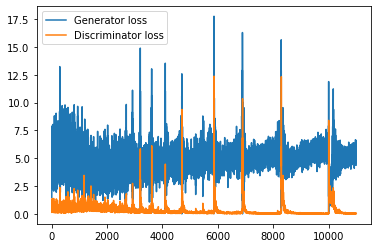

In [21]:
# Plot g_losses and d_losses
plt.plot(g_losses, label="Generator loss")
plt.plot(d_losses, label="Discriminator loss")
plt.legend()
plt.show()


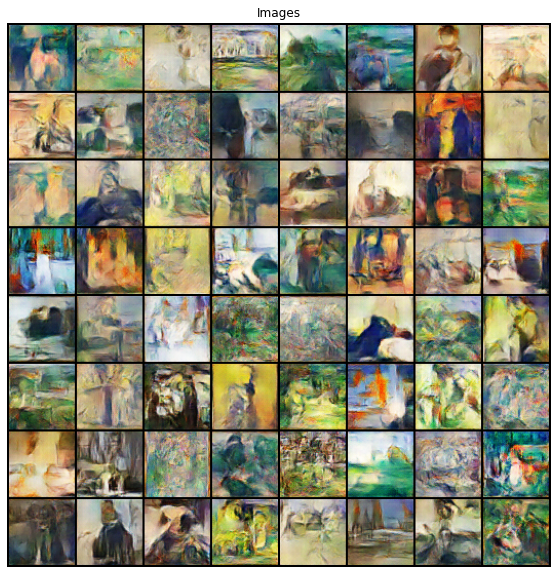

In [22]:
z = torch.randn(64, lsz, 1,1, device=device)
generator.eval()
with torch.no_grad():
    images = generator(z).detach().cpu()
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(images, padding=2, normalize=True).cpu(),(1,2,0)))

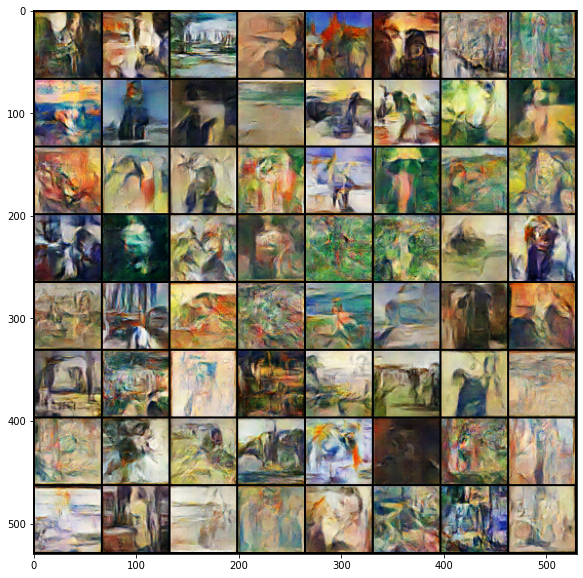

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = img_list # some array of images
frames = [] # for storing the generated images
fig = plt.figure(figsize=(10,10))
for i in range(len(img)):
    img_grid = np.transpose(torchvision.utils.make_grid(img[i], padding=2, normalize=True).cpu(),(1,2,0))
    frames.append([plt.imshow(img_grid, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')

In [27]:
from IPython.display import Video
Video("movie.mp4")